In [1]:
# 분별 모델
# 표정을보고 상대의 감정을 읽는다 - SVM, 다층퍼셉트론,컨볼류션 신경망, LSTM, 강화학습

In [2]:
# 생성모델
# GAN 

In [3]:
# 확률생성 모델을 MNIST 필기 숫자에 적용
import numpy as np
from tensorflow.keras.datasets import mnist

In [4]:
# 0만 추출
(x_train,y_train),(x_test,y_test) =  mnist.load_data()

In [71]:
# X = x_train[y_train==0]
X=x_train[np.isin(y_train,[0])]

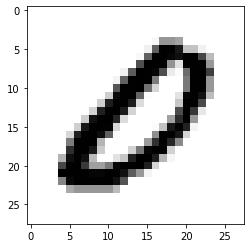

In [72]:
import matplotlib.pyplot as plt
plt.imshow(X[-2],cmap='gray_r')

In [84]:
import numpy as np
from tensorflow.keras.datasets import mnist

# MNIST 데이터를 읽고 0 패턴만 추출
(x_train,y_train),(x_test,y_test)=mnist.load_data()
X=x_train[np.isin(y_train,[0])]

# 화소 수준의 확률 생성 모델 구축
P=np.zeros((28,28,256))
for k in range(X.shape[0]):
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            P[i][j][X[k][i][j]]+=1
P=P/X.shape[0]

# 확률 생성 모델을 이용하여 20개 샘플을 생성
Xnew=np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]=np.random.choice(range(256),p=P[r][c])

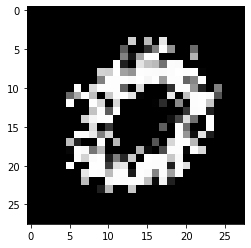

In [87]:
plt.imshow(Xnew[0],cmap='gray')

In [ ]:
# 오토인코더
# 입력패턴과 출력 패턴이 같은 신경망
# 사람이 레이블을 달 필요가 없음 비지도 학습
# 고전적인 응용 : 영상압축, 잡음제거
# 응용 : 특징 추출 또는  생성 모델
# 오토인코더를 생성 모델로 활용

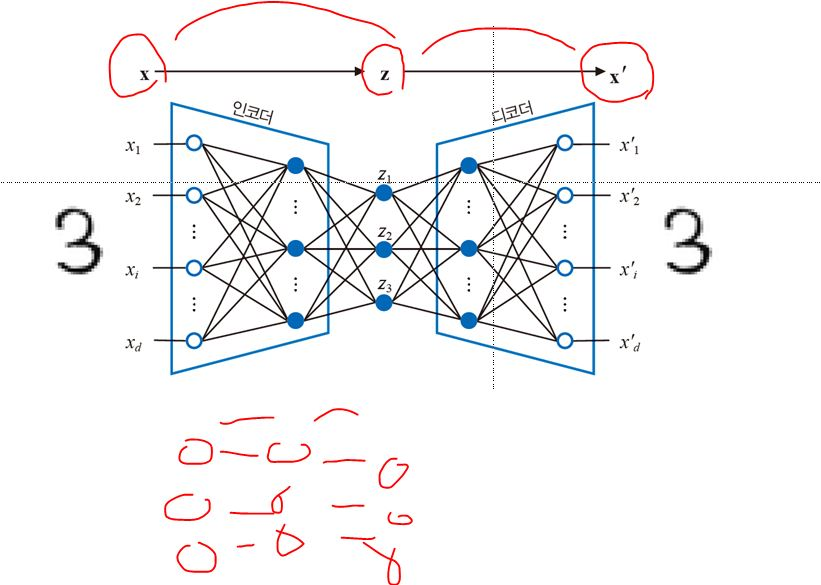

In [1]:
from IPython import display
display.Image('E:/1 강남야간/img/037.jpg',width=500, height=500)

In [ ]:
# 은닉층의 노드개수를 축소 설계
# 인코더는 차원을 축소-> 디코더는 차원을 회복, z공간을 잠복공간(latent space)

In [33]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [34]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

In [35]:
# 28*28 인 784차원을 32차원으로 축소
zdim = 32 # 잠복공간의 z차원을 32로  설정


In [36]:
#오토인코더의 인코더를  설정
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
model_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                1003

In [37]:
# 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
model_decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              103488    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       1846

In [38]:
# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

In [39]:
# 오토인코더 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/5
469/469 [==============================] - 99s 209ms/step - loss: 0.0222 - val_loss: 0.0069
Epoch 2/5
469/469 [==============================] - 92s 196ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 3/5
469/469 [==============================] - 92s 197ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/5
469/469 [==============================] - 93s 198ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/5
469/469 [==============================] - 92s 197ms/step - loss: 0.0038 - val_loss: 0.0036


In [40]:
# 복원 실험
decoded_img=model.predict(x_test)

313/313 [==============================] - 5s 15ms/step


In [41]:
import matplotlib.pyplot as plt

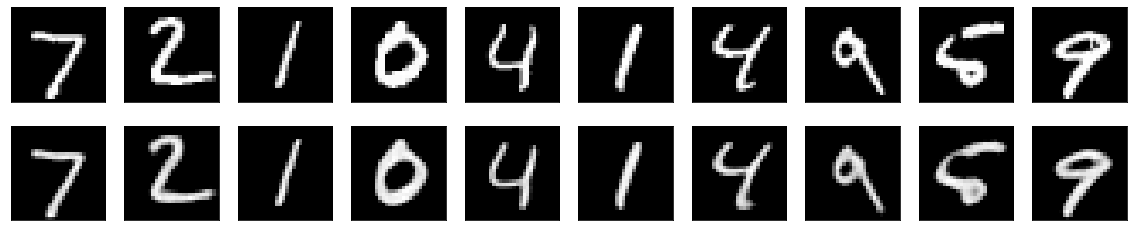

In [42]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()  

In [ ]:
# Functional API

In [ ]:
# 인코더에서 잠복차원은 전체데이터의 특징을 잘 반영--> 디코딩했을때 원본과 유사하게 나오면
# 인코더만 사용하면 특징을 잘 추출해내는 추출기로 활용
# 인코더 + 다층퍼셉트론(인공신경망) + SVM을 붙이면 훌륭한 필기 숫자 인식기가 됨
# 현재는 딥러닝 자체가 성능이 우수해서 인코더를 굳이 사용 안함
# 대신 생성모델로 사용

In [32]:
# 학습된 오토인코더를 생성 모델로 활용

In [50]:
# 생성실험, 첫 번째 샘플의 잠복공간표현에 잡음을 섞어 새로운 샘플을 생성
x0 =  x_test[0]
z = model_encoder.predict(x0.reshape(1,28,28,1))
np.round(z,3)

1/1 [==============================] - 0s 15ms/step


array([[ 0.252, -0.383,  0.207,  0.122,  0.913, -0.48 , -0.076,  0.125,
         0.982, -0.916, -0.39 , -0.268, -0.212,  0.101,  0.576, -1.756,
        -1.299,  0.539, -0.189,  0.241, -0.088,  0.387, -0.548, -0.337,
        -0.706, -0.399,  0.114, -1.622,  1.125, -0.022, -0.308,  0.67 ]],
      dtype=float32)

In [53]:
zz = np.zeros((20,zdim))
zz.shape

(20, 32)

In [54]:
# 잠복공간에 잡음을 섞음
for i in range(20):
    zz[i] = z[0]+(i-10)/10.0

In [57]:
# 디코더로 샘플을 생성
generated_img =  model_decoder.predict(zz)

1/1 [==============================] - 0s 109ms/step


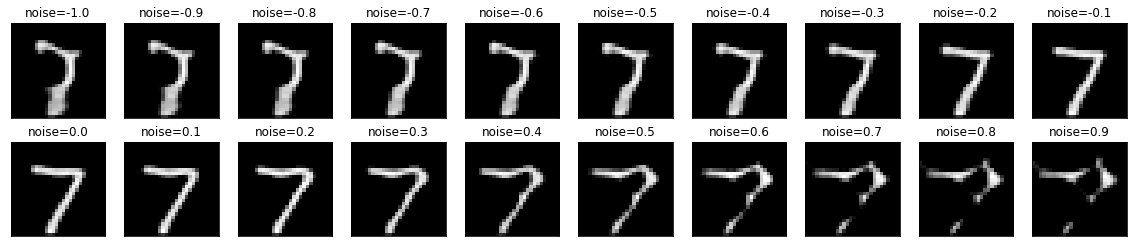

In [59]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('noise='+str((i-10)/10.0))
plt.show()    

In [76]:
x1,x2 = x_test[y_test== 8][0],x_test[y_test== 8][1]
# plt.imshow(x_test[18])

In [77]:
# 생성실험 2: 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성
x_2_20 = np.array((x1,x2))
z = model_encoder.predict(x_2_20)  # 잠복공간을 예측  32
zz = np.zeros((20,zdim))
# 두 잠복공간의 점을 잇는 선분상에서 20개 점 생성
for i in range(20):
    alpha = i/(20.0-1.0)
    zz[i] = (1.0-alpha)*z[0]+alpha*z[1]
# 두 사잇점에 대해 디코도러 샘플 생성
generated_img = model_decoder.predict(zz)
    

1/1 [==============================] - 0s 22ms/step


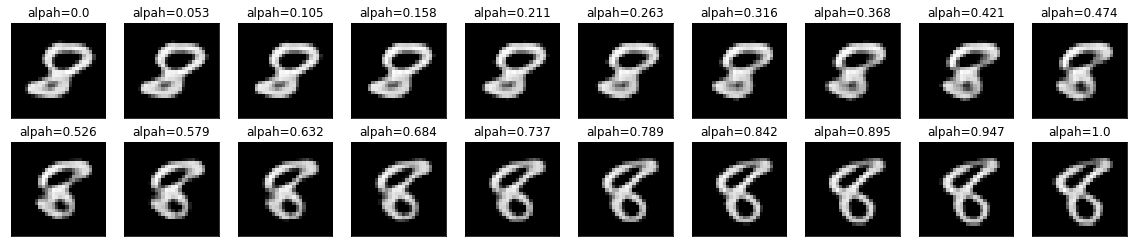

In [80]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('alpah='+str(round(i/(20.0-1.0),3)))
plt.show()    

In [ ]:
# 오토인코더는 생성모델로 가능성이 있음
# 잠복공간의 점들중에는품질이 떨어지는것이 다수 있음을 확인